<a href="https://colab.research.google.com/github/TrippleA001/Air-Quality-Index-for-Urban-vs-Rural-Nigeria/blob/main/Individual/Anyigba_PM10_pollutants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build models for prediction
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR

# To encode categorical variables
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# For tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# To check model performance
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
df= pd.ExcelFile("/content/drive/MyDrive/PM 2.5 and PM 10 Prediction for PhD Physics/Anyigba's Data.xlsx")
data = pd.read_excel(df, 'Anyigba Hourly')

Mounted at /content/drive/


In [3]:
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
0,2021-05-01,01:00:00,25.58,87.48,985.99,3.92,223.82,10.6100,19.9925,21.6685
1,2021-05-01,02:00:00,25.29,89.38,985.48,3.86,226.89,6.0055,14.4795,15.0275
2,2021-05-01,03:00:00,25.09,90.59,985.12,3.66,230.60,3.6550,10.6975,11.2175
3,2021-05-01,04:00:00,24.94,91.42,985.00,3.37,235.68,2.9915,9.6235,10.2240
4,2021-05-01,05:00:00,24.82,91.95,985.05,3.20,243.02,3.9745,12.8320,13.2980
...,...,...,...,...,...,...,...,...,...,...
12038,2023-04-28,18:00:00,29.01,72.40,987.64,1.27,258.35,1.6520,2.4955,2.6600
12039,2023-04-28,19:00:00,27.97,76.78,988.39,1.48,258.36,3.1525,4.5895,4.8660
12040,2023-04-28,20:00:00,27.35,78.46,989.14,1.72,255.03,3.6600,5.2425,5.4920
12041,2023-04-28,21:00:00,26.75,80.50,989.88,1.97,249.67,4.2825,6.2045,6.5165


In [4]:
# summary statistics for the data used in buiding the ML algorithms
data.describe()

,Date,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
count,12043,12043.000000,12043.000000,12043.000000,12043.000000,12043.000000,12040.000000,12042.000000,12040.000000
mean,2022-04-12 20:13:31.890724864,25.299094,78.301769,988.957844,2.509674,191.649738,9.632697,14.211066,15.920253
min,2021-05-01 00:00:00,12.010000,27.990000,982.180000,0.030000,0.040000,0.000000,0.000000,0.000000
25%,2021-10-28 00:00:00,23.230000,68.790000,987.680000,1.720000,138.470000,2.859750,4.476625,4.792875
50%,2022-04-19 00:00:00,24.990000,80.980000,989.030000,2.330000,217.430000,5.659750,8.636500,9.263250
75%,2022-09-19 00:00:00,27.730000,91.845000,990.290000,3.200000,237.910000,11.451875,17.131500,19.057250
max,2023-04-28 00:00:00,34.600000,101.030000,995.250000,8.020000,359.860000,1577.058000,1577.117000,1577.131500
std,NaN,3.252561,15.077515,1.936786,1.151133,79.484868,19.940124,22.772243,24.245023


In [5]:
# Checking for duplicate values in the data
data.duplicated().sum()

np.int64(0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            12043 non-null  datetime64[ns]
 1   Time            12043 non-null  object        
 2   Temp(deg)       12043 non-null  float64       
 3   Hum(%)          12043 non-null  float64       
 4   Pre(hPa)        12043 non-null  float64       
 5   WS (m/s)        12043 non-null  float64       
 6   Wind direction  12043 non-null  float64       
 7   PM1(µg/m^3)     12040 non-null  float64       
 8   PM2.5(µg/m^3)   12042 non-null  float64       
 9   PM10(µg/m^3)    12040 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 941.0+ KB


In [7]:
data.isnull().sum()

,0
Date,0
Time,0
Temp(deg),0
Hum(%),0
Pre(hPa),0
WS (m/s),0
Wind direction,0
PM1(µg/m^3),3
PM2.5(µg/m^3),1
PM10(µg/m^3),3


In [8]:
data[data.isnull().any(axis=1)]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
213,2021-05-10,13:00:00,33.39,45.65,988.74,3.74,148.97,NaN,7.40,NaN
1802,2021-08-26,09:00:00,25.51,87.51,989.55,3.36,241.72,NaN,8.20,NaN
2298,2021-09-24,10:00:00,27.07,77.51,991.89,2.42,243.58,NaN,13.05,NaN
2478,2021-10-01,23:00:00,23.87,94.37,990.16,1.90,243.54,10.26,NaN,15.76


In [9]:
data.dropna(inplace=True)

<Axes: ylabel='PM10(µg/m^3)'>

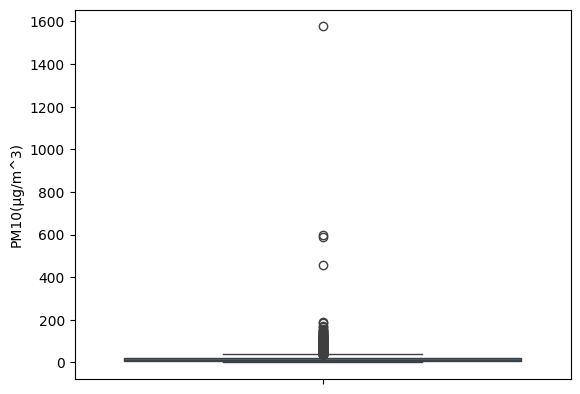

In [10]:
# Checking for outliers
sns.boxplot(data['PM10(µg/m^3)'])

In [11]:
#Outlier Detection using IQR
# Calculate the upper and lower limits
Q1 = data['PM10(µg/m^3)'].quantile(0.25)
Q3 = data['PM10(µg/m^3)'].quantile(0.75)
IQR = Q3 - Q1
lower = Q3 - 3*IQR
upper = Q3 + 3*IQR

# Create arrays of Boolean values indicating the outlier rows
data = data[(data['PM10(µg/m^3)'] < upper) & (data['PM10(µg/m^3)'] > lower)]
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
0,2021-05-01,01:00:00,25.58,87.48,985.99,3.92,223.82,10.6100,19.9925,21.6685
1,2021-05-01,02:00:00,25.29,89.38,985.48,3.86,226.89,6.0055,14.4795,15.0275
2,2021-05-01,03:00:00,25.09,90.59,985.12,3.66,230.60,3.6550,10.6975,11.2175
3,2021-05-01,04:00:00,24.94,91.42,985.00,3.37,235.68,2.9915,9.6235,10.2240
4,2021-05-01,05:00:00,24.82,91.95,985.05,3.20,243.02,3.9745,12.8320,13.2980
...,...,...,...,...,...,...,...,...,...,...
12038,2023-04-28,18:00:00,29.01,72.40,987.64,1.27,258.35,1.6520,2.4955,2.6600
12039,2023-04-28,19:00:00,27.97,76.78,988.39,1.48,258.36,3.1525,4.5895,4.8660
12040,2023-04-28,20:00:00,27.35,78.46,989.14,1.72,255.03,3.6600,5.2425,5.4920
12041,2023-04-28,21:00:00,26.75,80.50,989.88,1.97,249.67,4.2825,6.2045,6.5165


In [12]:
data[(data['PM10(µg/m^3)'] < 1)]["PM10(µg/m^3)"]=1

In [13]:
data.describe()

,Date,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
count,11695,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000,11695.000000
mean,2022-04-15 00:21:32.860196608,25.393599,78.546892,988.972369,2.530823,192.346149,8.070911,12.139315,13.669236
min,2021-05-01 00:00:00,12.010000,27.990000,982.180000,0.040000,0.040000,0.000000,0.000000,0.000000
25%,2021-10-24 00:00:00,23.310000,69.110000,987.690000,1.740000,147.590000,2.796750,4.373000,4.718250
50%,2022-04-27 00:00:00,25.080000,81.500000,989.050000,2.360000,217.620000,5.444500,8.373500,8.967500
75%,2022-09-22 00:00:00,27.810000,92.030000,990.330000,3.220000,237.620000,10.679500,16.051500,17.562250
max,2023-04-28 00:00:00,34.600000,101.030000,995.250000,8.020000,359.860000,42.772500,58.086500,61.241500
std,NaN,3.212067,15.111632,1.947131,1.153240,77.826952,7.621744,11.134178,13.039073


In [14]:
data["Time"].apply(lambda x: isinstance(x, datetime.time)).sum()

np.int64(11225)

In [15]:
data[~data["Time"].apply(lambda x: isinstance(x, datetime.time))]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
23,2021-05-01,"1 day, 0:00:00",25.54,91.09,986.95,3.85,194.08,6.3360,14.7095,15.3850
47,2021-05-02,"1 day, 0:00:00",25.49,88.76,986.49,3.99,216.55,2.7270,11.5775,12.3460
71,2021-05-03,"1 day, 0:00:00",25.10,91.00,987.20,3.45,216.38,5.0335,7.2165,7.7545
104,2021-05-05,"1 day, 0:00:00",25.26,87.87,988.05,4.44,215.64,6.8790,9.8860,10.5055
128,2021-05-06,"1 day, 0:00:00",24.25,92.99,989.89,3.77,225.11,8.4795,11.7950,12.6900
...,...,...,...,...,...,...,...,...,...,...
11924,2023-04-23,"1 day, 0:00:00",25.57,92.17,987.98,3.72,207.10,1.9830,2.9550,3.1290
11948,2023-04-24,"1 day, 0:00:00",25.51,85.92,988.16,1.47,221.98,4.9445,7.1495,7.4835
11972,2023-04-25,"1 day, 0:00:00",24.98,94.11,987.28,3.29,226.33,7.5300,11.5210,12.0340
11996,2023-04-26,"1 day, 0:00:00",24.96,91.31,987.46,3.32,225.29,5.2690,7.9320,8.3030


In [16]:
data.loc[~data["Time"].apply(lambda x: isinstance(x, datetime.time)), "Time"] = "00:00:00"

In [17]:
data[~data["Time"].apply(lambda x: isinstance(x, datetime.time))]

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3)
23,2021-05-01,00:00:00,25.54,91.09,986.95,3.85,194.08,6.3360,14.7095,15.3850
47,2021-05-02,00:00:00,25.49,88.76,986.49,3.99,216.55,2.7270,11.5775,12.3460
71,2021-05-03,00:00:00,25.10,91.00,987.20,3.45,216.38,5.0335,7.2165,7.7545
104,2021-05-05,00:00:00,25.26,87.87,988.05,4.44,215.64,6.8790,9.8860,10.5055
128,2021-05-06,00:00:00,24.25,92.99,989.89,3.77,225.11,8.4795,11.7950,12.6900
...,...,...,...,...,...,...,...,...,...,...
11924,2023-04-23,00:00:00,25.57,92.17,987.98,3.72,207.10,1.9830,2.9550,3.1290
11948,2023-04-24,00:00:00,25.51,85.92,988.16,1.47,221.98,4.9445,7.1495,7.4835
11972,2023-04-25,00:00:00,24.98,94.11,987.28,3.29,226.33,7.5300,11.5210,12.0340
11996,2023-04-26,00:00:00,24.96,91.31,987.46,3.32,225.29,5.2690,7.9320,8.3030


In [18]:
#  Convert DateTime values to time
i = 0
for x in data["Time"] :
  if not isinstance (x, datetime.time):
    data["Time"].iloc[i] = datetime.datetime.strptime(str(x), "%H:%M:%S").time()
  i += 1

In [19]:
data["Wind direction"].value_counts()

,count
Wind direction,
216.61,8
207.54,7
207.83,7
234.70,6
220.53,6
...,...
213.55,1
229.54,1
224.75,1


In [20]:
def wind_deg_to_str2(deg):
        arr = ['NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW', 'N']
        return arr[int(abs((deg - 11.25) % 360)/ 22.5)]

In [21]:
# Feature Engineering

data["DateTime"] = [datetime.datetime.combine(data["Date"].dt.date.iloc[i], data["Time"].iloc[i]) for i in range(len(data))]
data["Year"] =  data["DateTime"].dt.year
data["Month"] = data["DateTime"].dt.month
data["Day"] = data["DateTime"].dt.day
data["Hour"] = data["DateTime"].dt.hour
data["Direction"] = data['Wind direction'].map(wind_deg_to_str2)
encoded_directions = pd.get_dummies(data.Direction, dtype=int)

In [22]:
data = pd.concat([data, encoded_directions], axis = 1)
data.set_index("DateTime", inplace=True)
data

,Date,Time,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,PM1(µg/m^3),PM2.5(µg/m^3),PM10(µg/m^3),Year,Month,Day,Hour,Direction,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-01 01:00:00,2021-05-01,01:00:00,25.58,87.48,985.99,3.92,223.82,10.6100,19.9925,21.6685,2021,5,1,1,SW,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2021-05-01 02:00:00,2021-05-01,02:00:00,25.29,89.38,985.48,3.86,226.89,6.0055,14.4795,15.0275,2021,5,1,2,SW,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2021-05-01 03:00:00,2021-05-01,03:00:00,25.09,90.59,985.12,3.66,230.60,3.6550,10.6975,11.2175,2021,5,1,3,SW,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2021-05-01 04:00:00,2021-05-01,04:00:00,24.94,91.42,985.00,3.37,235.68,2.9915,9.6235,10.2240,2021,5,1,4,SW,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2021-05-01 05:00:00,2021-05-01,05:00:00,24.82,91.95,985.05,3.20,243.02,3.9745,12.8320,13.2980,2021,5,1,5,WSW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28 18:00:00,2023-04-28,18:00:00,29.01,72.40,987.64,1.27,258.35,1.6520,2.4955,2.6600,2023,4,28,18,WSW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2023-04-28 19:00:00,2023-04-28,19:00:00,27.97,76.78,988.39,1.48,258.36,3.1525,4.5895,4.8660,2023,4,28,19,WSW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2023-04-28 20:00:00,2023-04-28,20:00:00,27.35,78.46,989.14,1.72,255.03,3.6600,5.2425,5.4920,2023,4,28,20,WSW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
data["Direction"].value_counts()

,count
Direction,
SW,3308
WSW,1744
SSW,1711
ENE,805
E,702
W,536
S,442
NE,405
NNE,344


<Figure size 2500x1000 with 0 Axes>

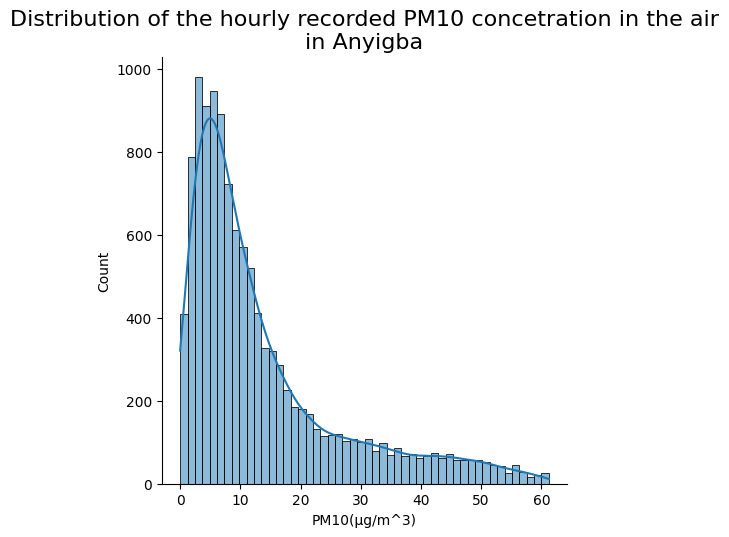

In [24]:
plt.figure(figsize=(25,10))
sns.displot(data['PM10(µg/m^3)'],bins=50, kde = True, lw=5)
plt.title('Distribution of the hourly recorded PM10 concetration in the air\nin Anyigba',
          fontsize=16)
plt.show();

In [25]:
# find the daily average of PM10 contained in the air in any given hour
monthly_data = data[['PM10(µg/m^3)']]
monthly_data = monthly_data.resample('M').median()
monthly_data.interpolate(inplace=True)

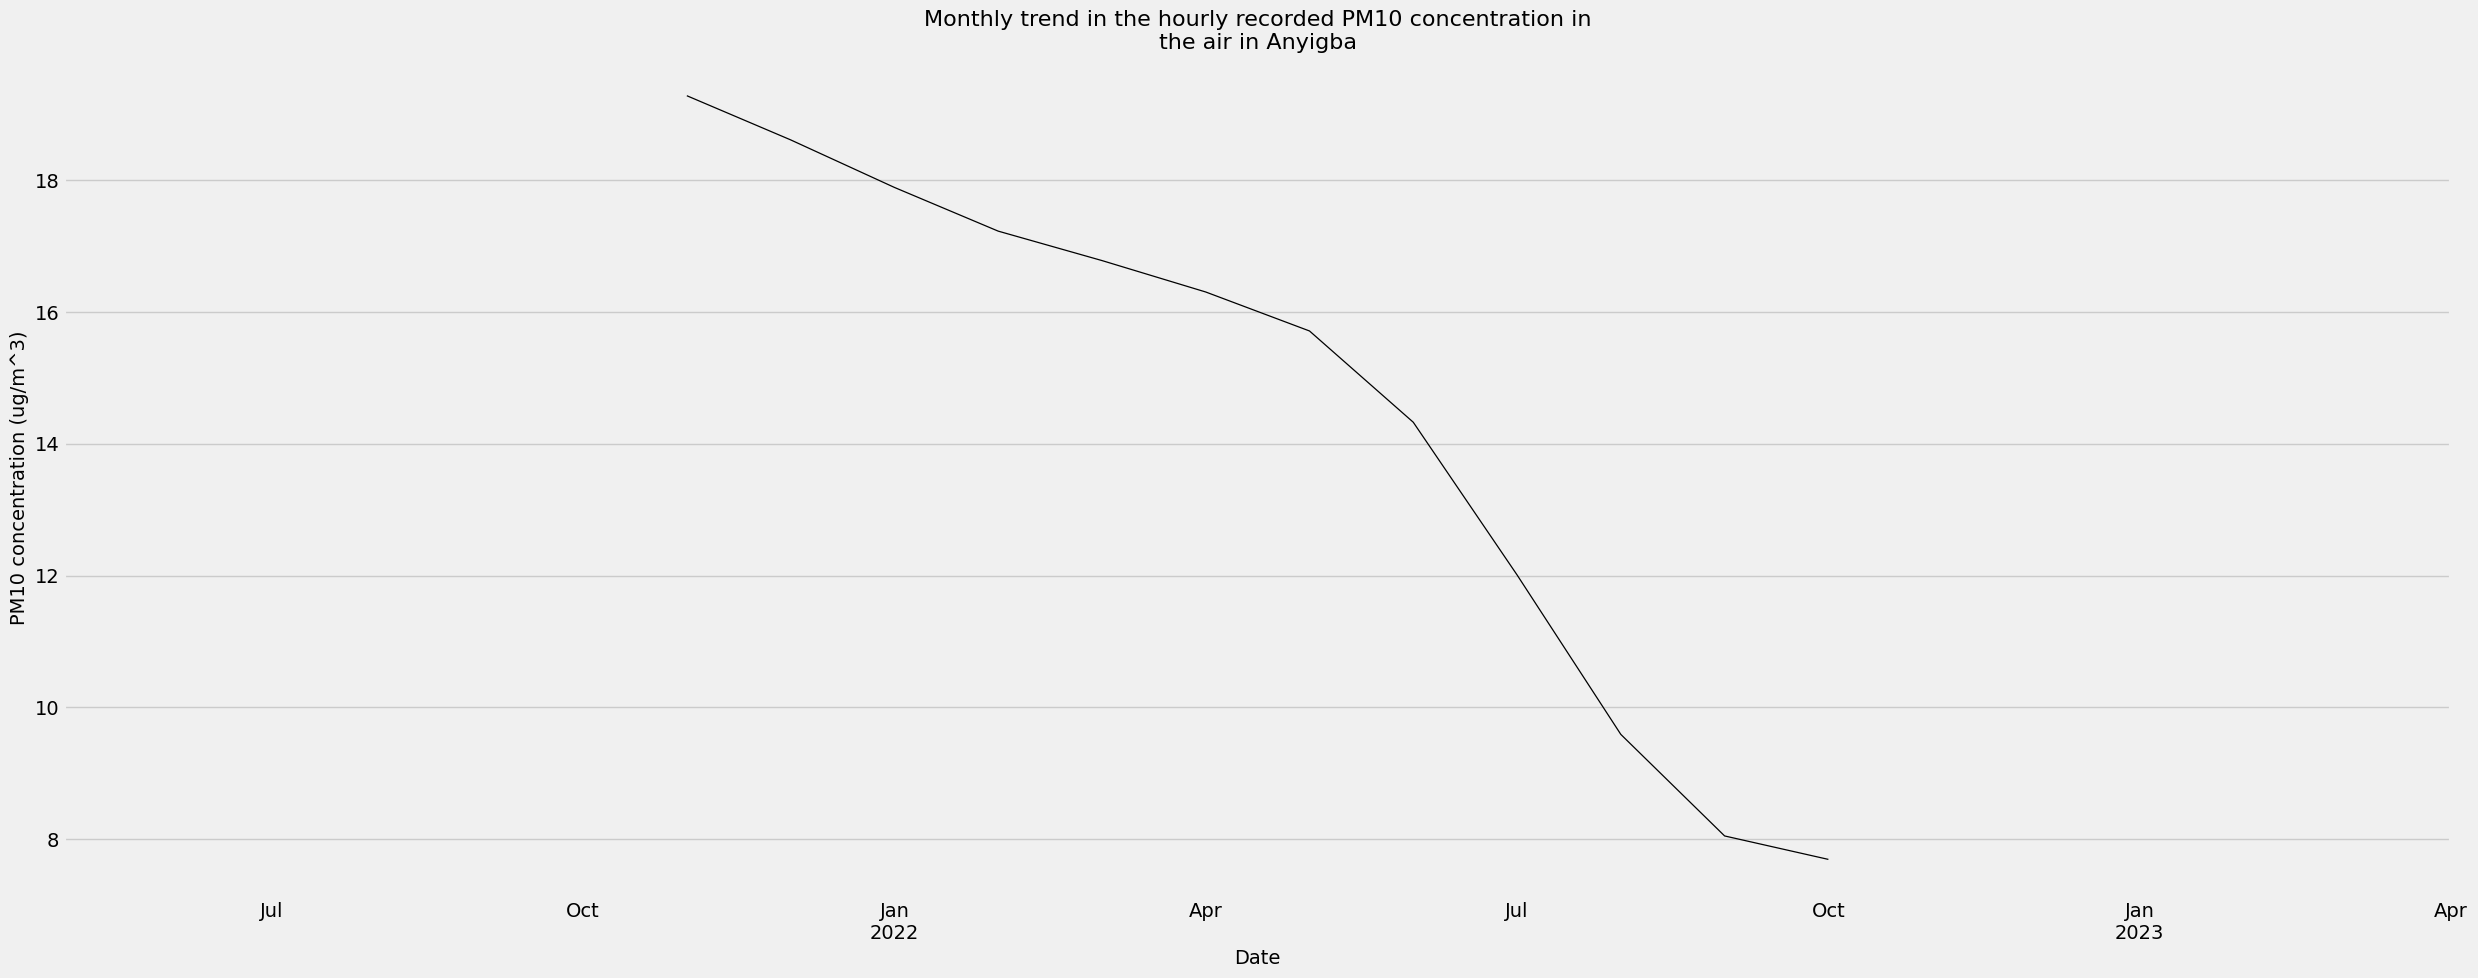

In [26]:
decomposition = seasonal_decompose(monthly_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(25,10),style='k-',linewidth=.9,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly trend in the hourly recorded PM10 concentration in\nthe air in Anyigba',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

In [27]:
daily_data = data[['PM10(µg/m^3)']]
daily_data = daily_data.resample('D').median()

In [28]:
daily_data.interpolate(inplace=True)

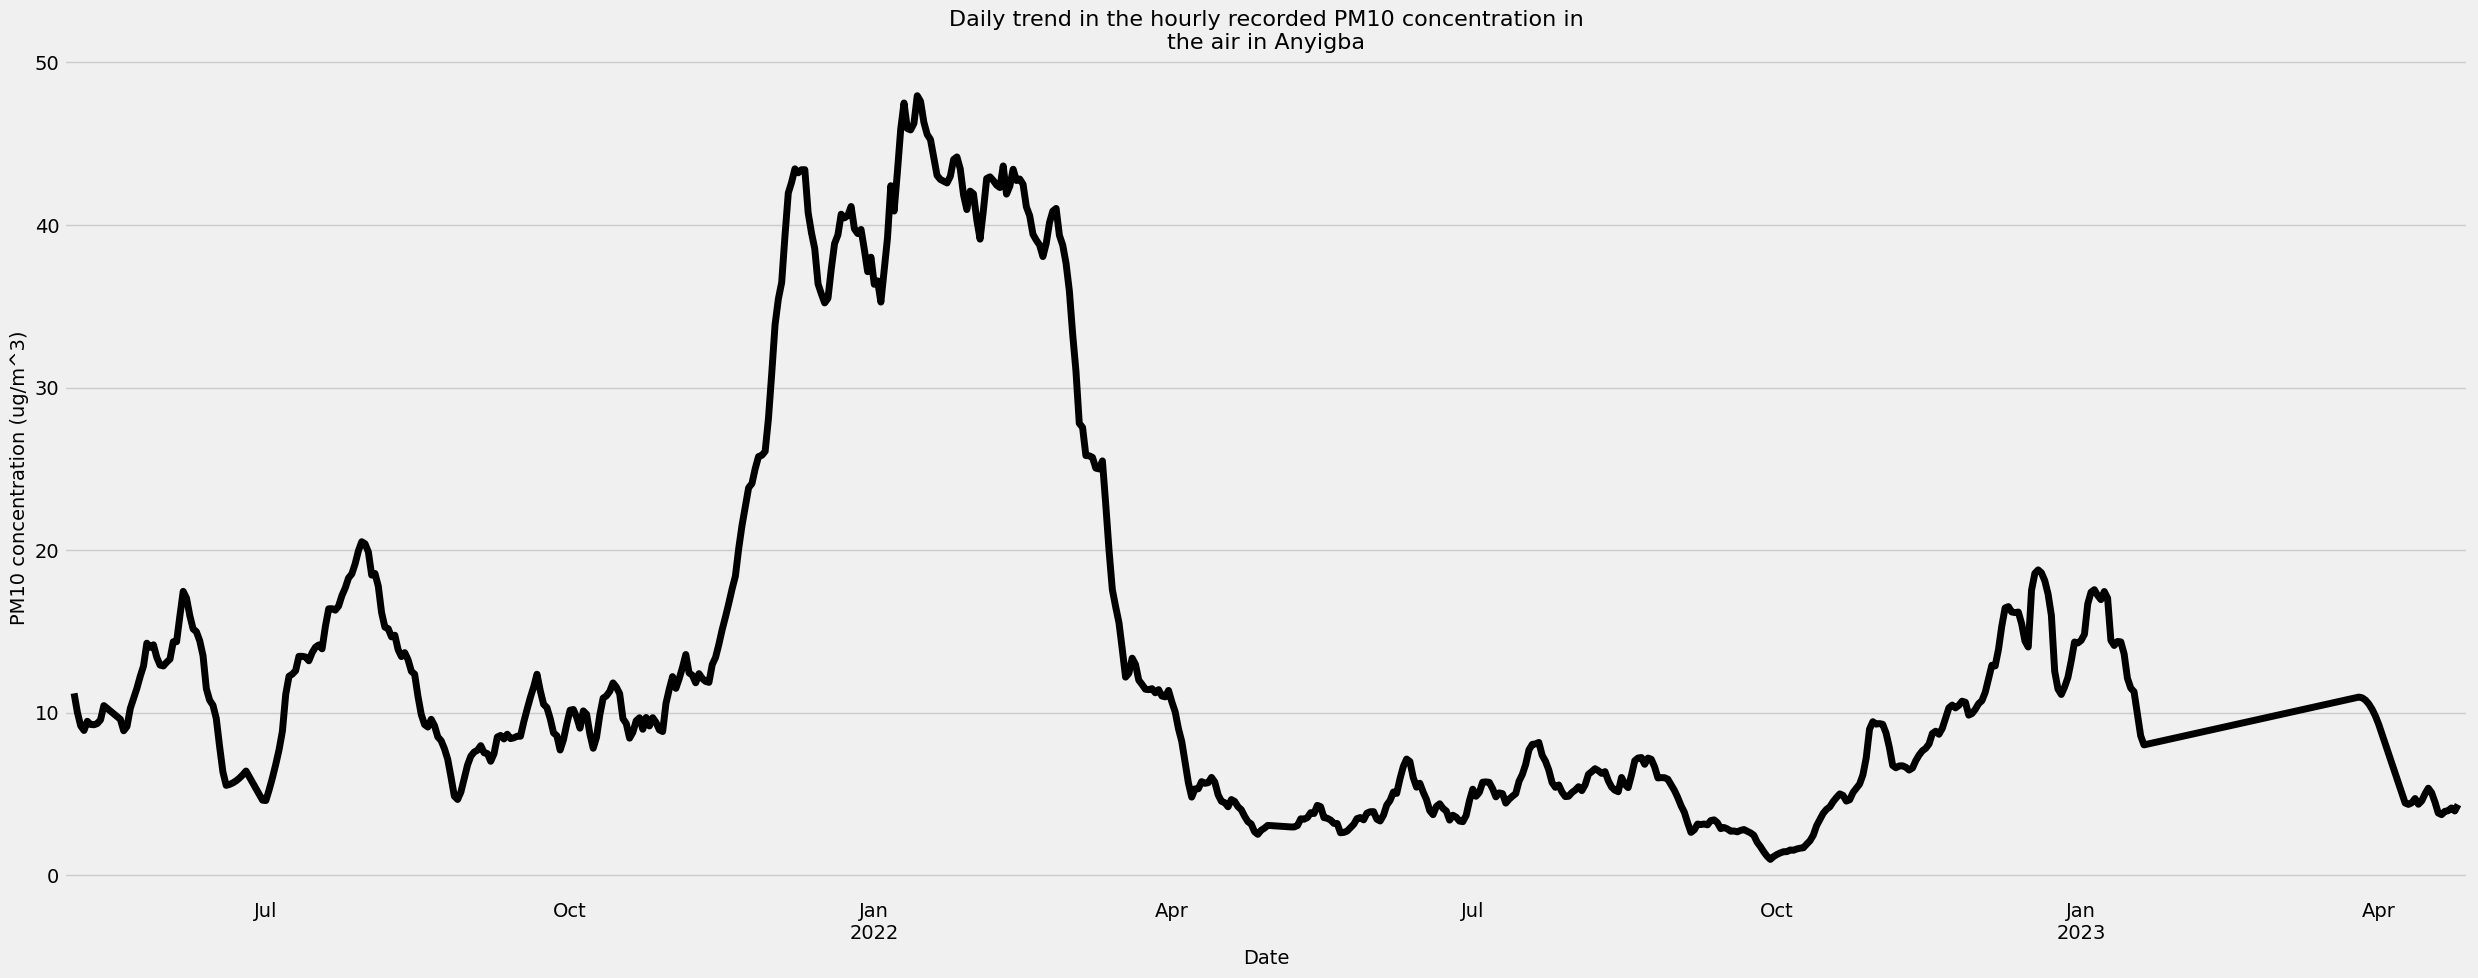

In [29]:
decomposition = seasonal_decompose(daily_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(25,10),style='k-',linewidth=5,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Daily trend in the hourly recorded PM10 concentration in\nthe air in Anyigba',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

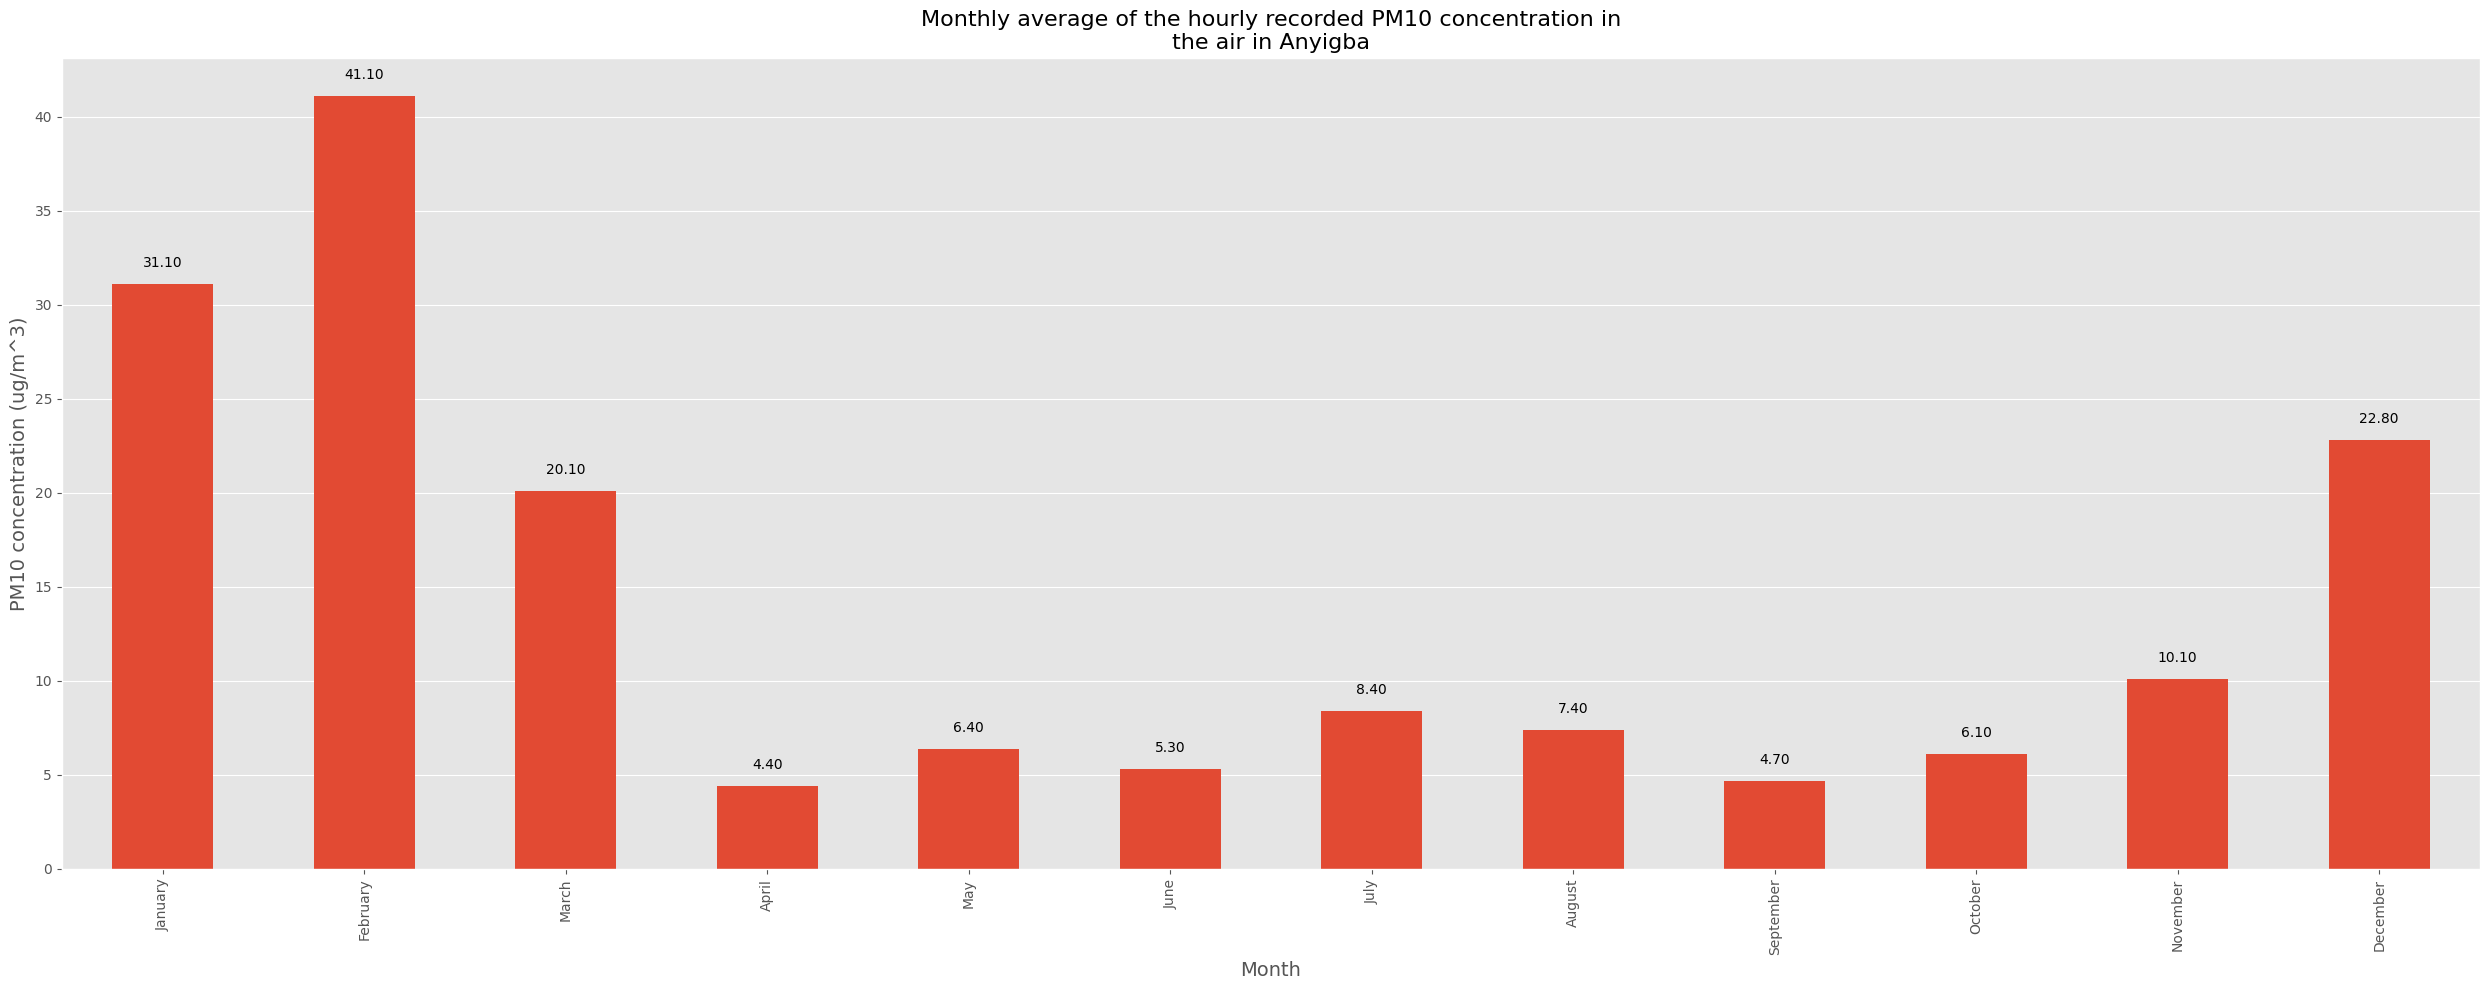

In [30]:
monthly_data = data[['Month','PM10(µg/m^3)']]
month = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(month,columns=['month'])
map_dict = {}
for i,j in enumerate(month):
    map_dict.setdefault(i+1,j)

monthly_data.Month = monthly_data.Month.map(map_dict)
monthly_average = monthly_data.groupby('Month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(25, 10),legend=False,kind='bar',linewidth=5)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM10 concentration in\nthe air in Anyigba',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

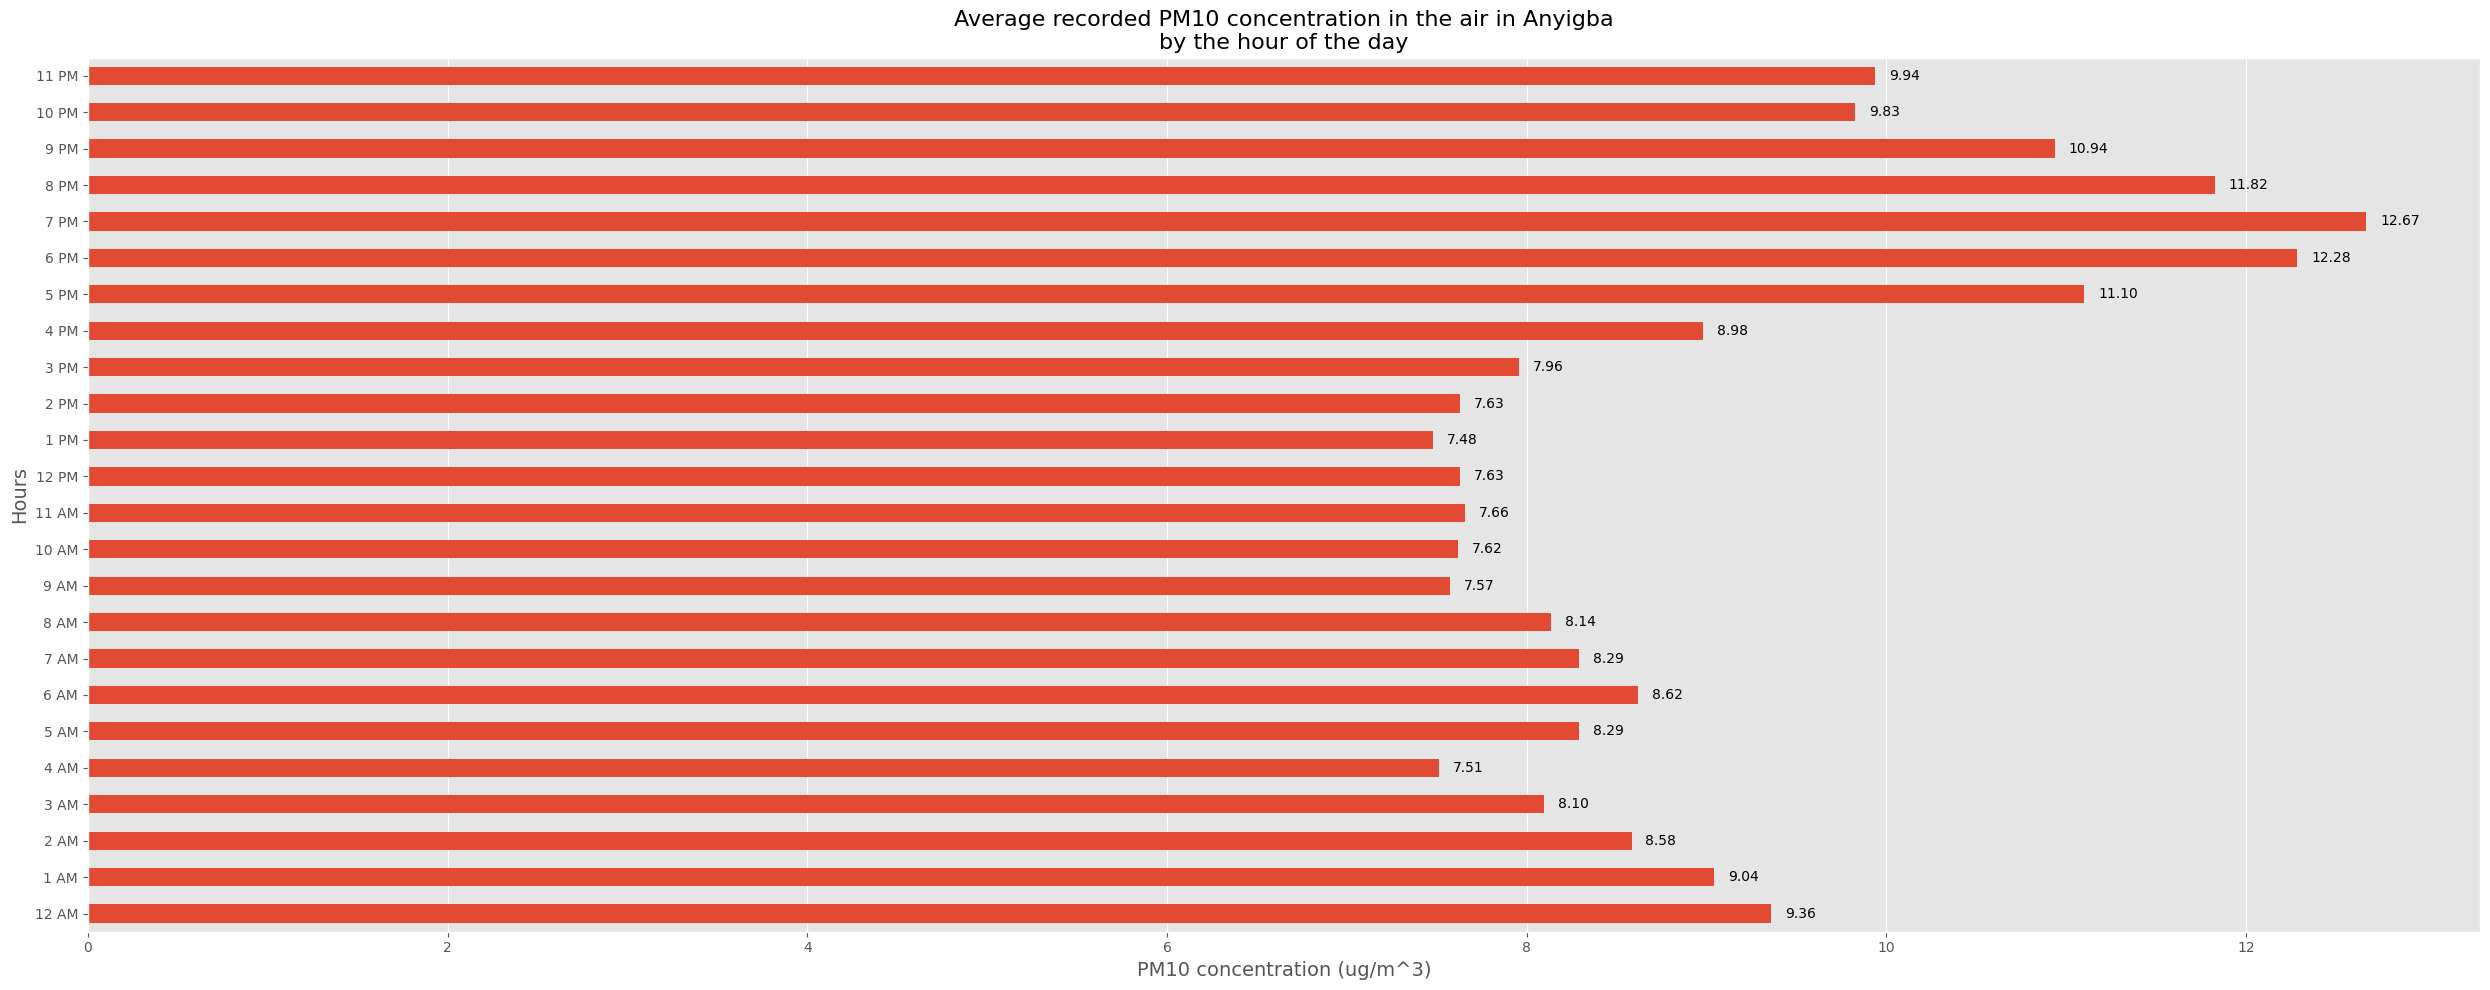

In [31]:
hourly_data = data[['Hour','PM10(µg/m^3)']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)

hourly_data = hourly_data.groupby('Hour').median().reset_index()
hourly_data.Hour = hourly_data.Hour.map(hour_dict)
hourly_data = hourly_data.set_index('Hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(25,10),legend=False,kind='barh',linewidth=5)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM10 concentration in the air in Anyigba\nby the hour of the day',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show();

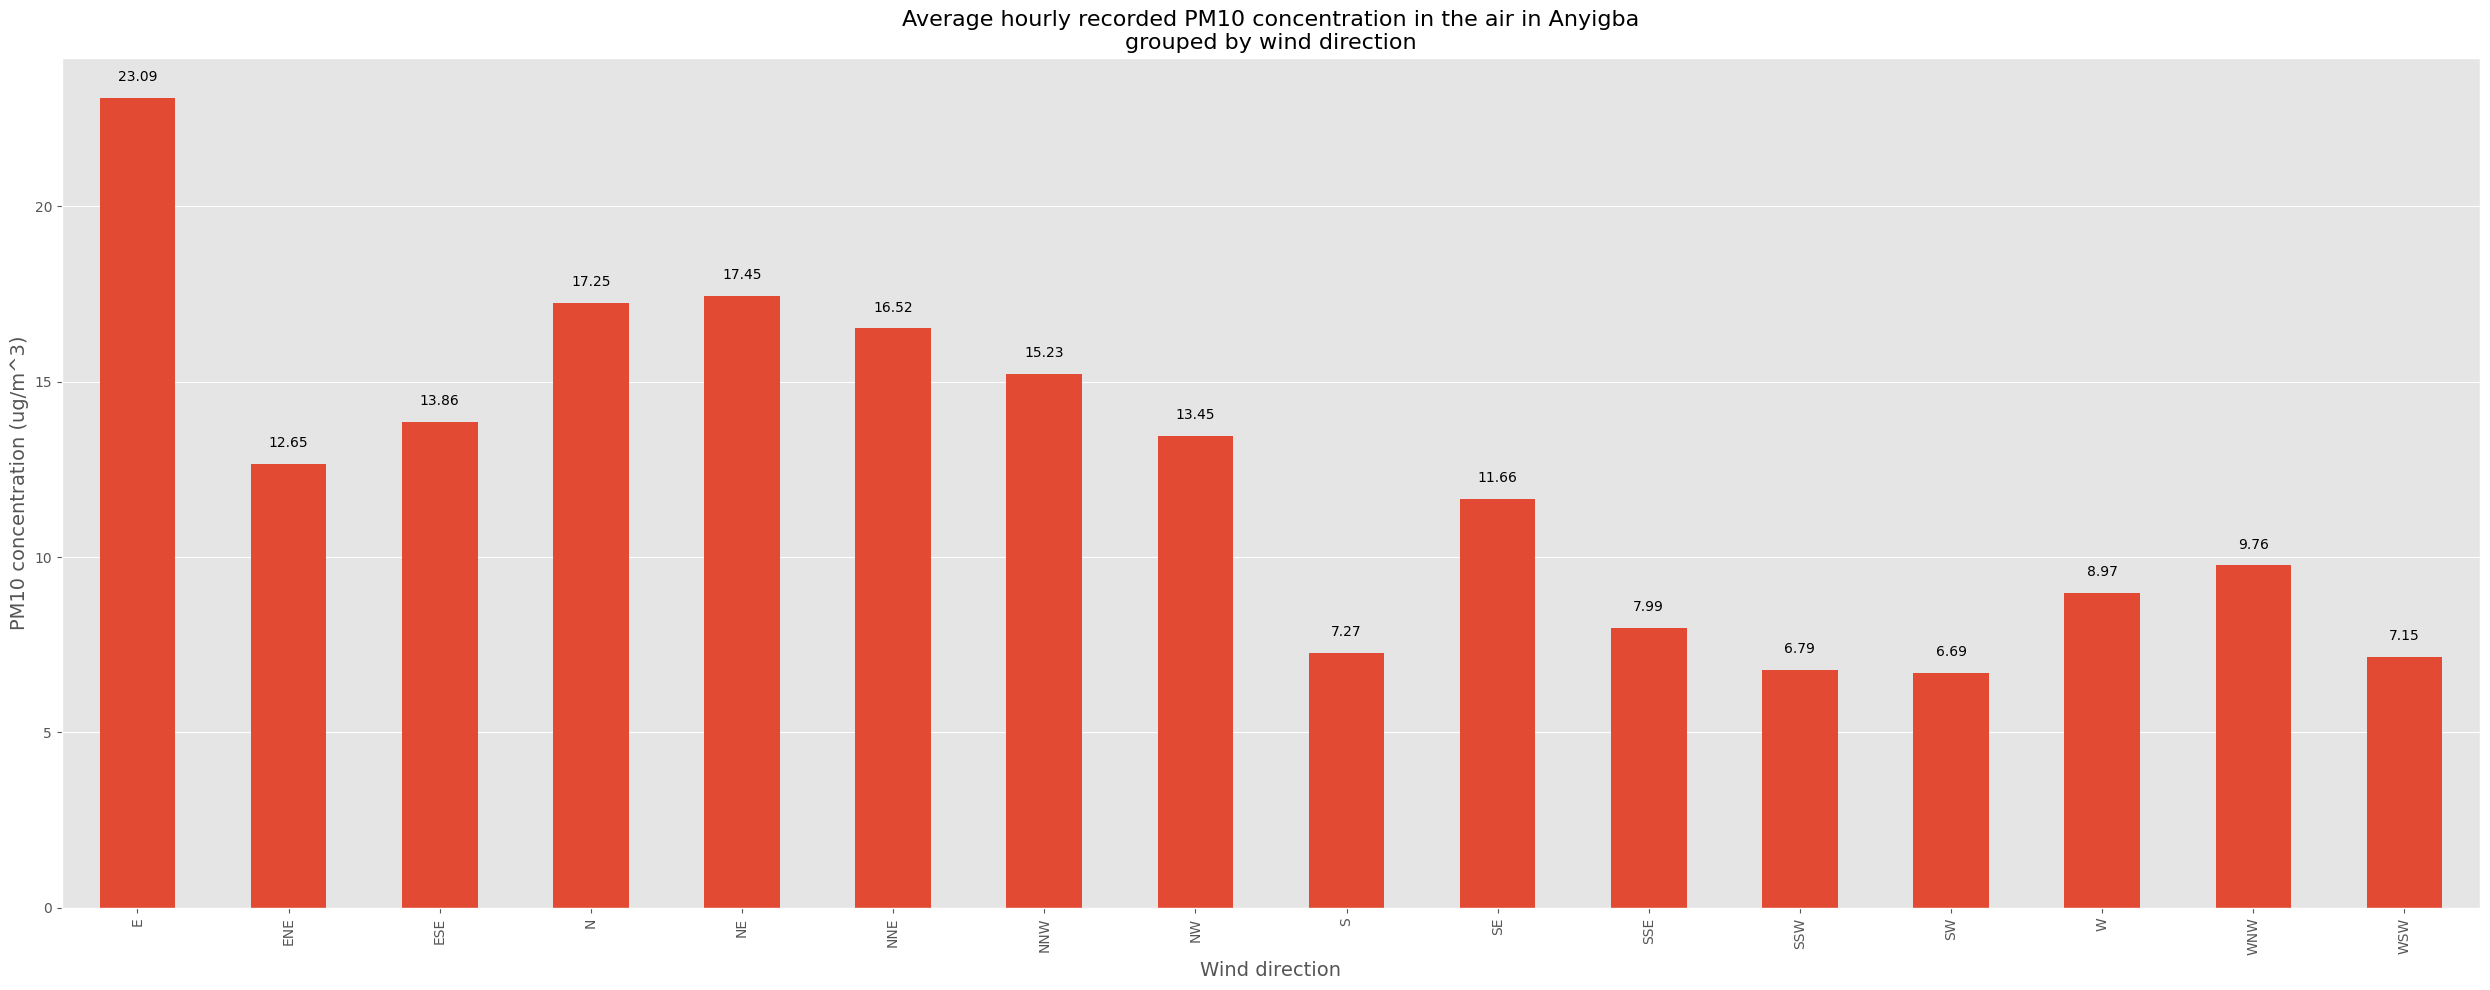

In [32]:
wind_dir = data[['Direction','PM10(µg/m^3)']]
wind_dir = wind_dir.groupby('Direction').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(25,10),legend=False,kind='bar',linewidth=5)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM10 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM10 concentration in the air in Anyigba\ngrouped by wind direction',fontsize=16)
    # Get the current Axes object
    ax = plt.gca()
    # Add value labels on top of bars
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=10)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show();

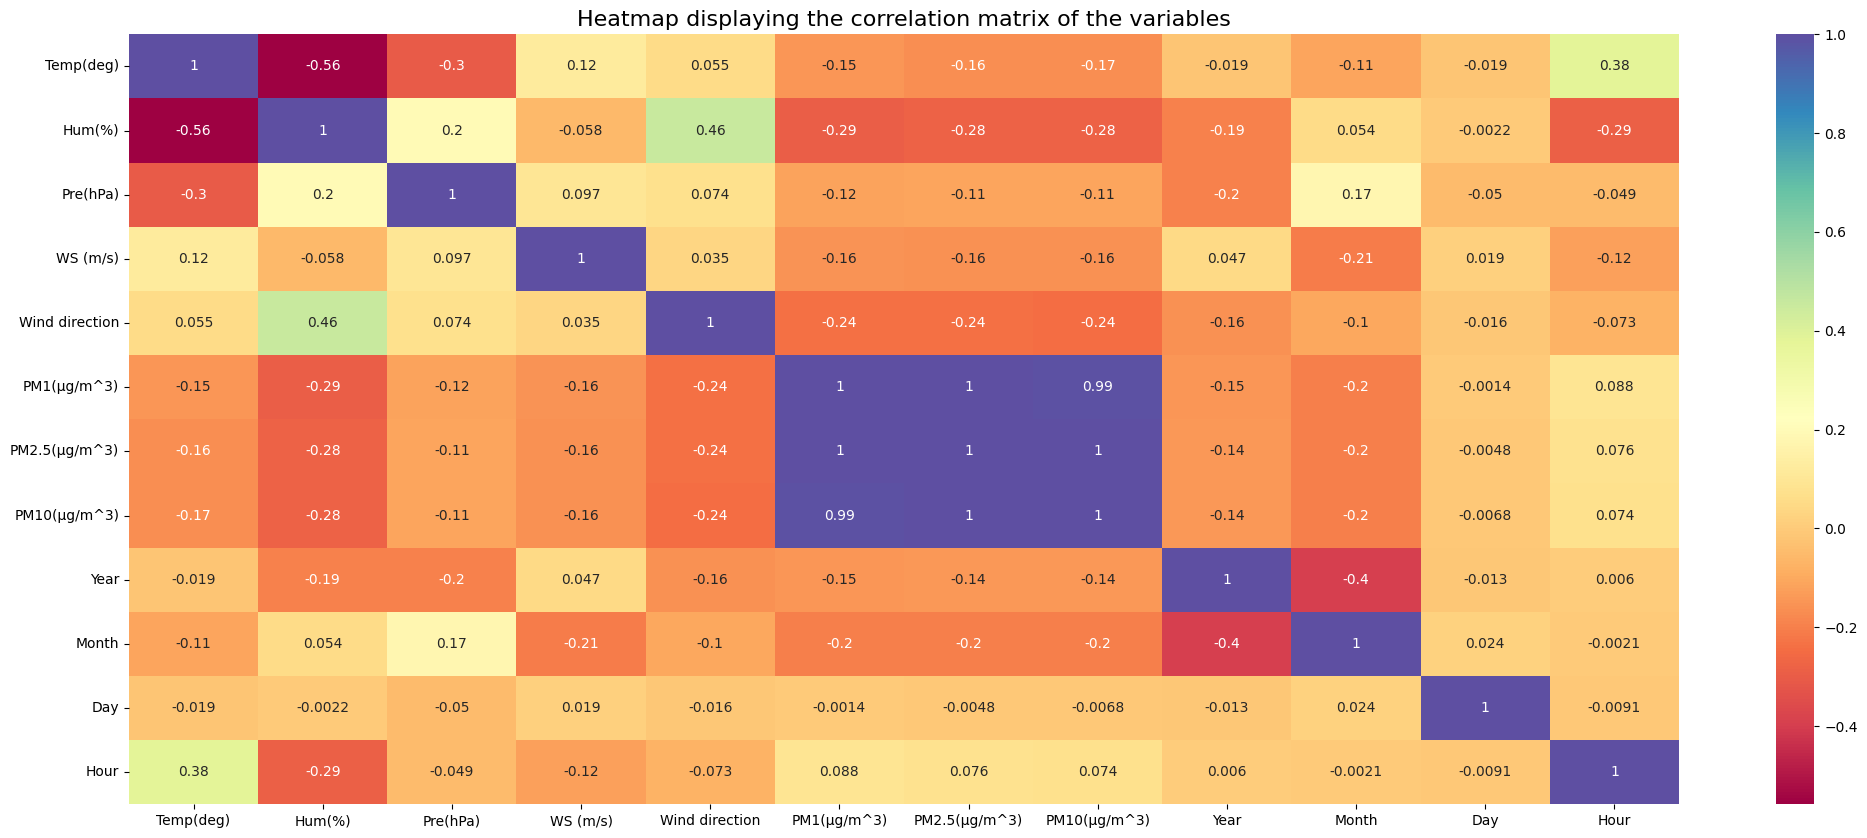

In [33]:
# Visualize the relationships between the features of the data
plt.figure(figsize=(25,10))
correlation_data = data[['Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)',
       'Wind direction', 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)',
       'Year', 'Month', 'Day', 'Hour',]]
sns.heatmap(correlation_data.corr(),annot = True,cmap="Spectral",)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show();

Model Training and Evaluation

In [34]:
data.columns

Index(['Date', 'Time', 'Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)',
       'Wind direction', 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)',
       'Year', 'Month', 'Day', 'Hour', 'Direction', 'E', 'ENE', 'ESE', 'N',
       'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW',
       'WSW'],
      dtype='object')

In [35]:
cols_to_drop = ['Date', 'Time', 'Direction' , 'PM1(µg/m^3)', 'PM2.5(µg/m^3)', 'PM10(µg/m^3)']
X = data.drop(cols_to_drop,axis=1)
y= data['PM10(µg/m^3)']

In [36]:
# Function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    pred = model.predict(predictors)                  # Predict using the independent variables
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [37]:
# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,Temp(deg),Hum(%),Pre(hPa),WS (m/s),Wind direction,Year,Month,Day,Hour,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0.058034,0.591166,-1.531740,1.204638,0.404425,-1.282931,-0.704652,-1.724319,-1.541181,-0.252703,-0.271884,-0.17304,-0.141637,-0.1894,-0.174085,-0.119258,-0.135221,-0.198188,-0.131905,-0.138463,-0.413974,1.592284,-0.219164,-0.171461,-0.418639
1,-0.032254,0.716903,-1.793675,1.152609,0.443874,-1.282931,-0.704652,-1.724319,-1.394956,-0.252703,-0.271884,-0.17304,-0.141637,-0.1894,-0.174085,-0.119258,-0.135221,-0.198188,-0.131905,-0.138463,-0.413974,1.592284,-0.219164,-0.171461,-0.418639
2,-0.094522,0.796977,-1.978570,0.979177,0.491545,-1.282931,-0.704652,-1.724319,-1.248731,-0.252703,-0.271884,-0.17304,-0.141637,-0.1894,-0.174085,-0.119258,-0.135221,-0.198188,-0.131905,-0.138463,-0.413974,1.592284,-0.219164,-0.171461,-0.418639
3,-0.141223,0.851904,-2.040202,0.727701,0.556821,-1.282931,-0.704652,-1.724319,-1.102506,-0.252703,-0.271884,-0.17304,-0.141637,-0.1894,-0.174085,-0.119258,-0.135221,-0.198188,-0.131905,-0.138463,-0.413974,1.592284,-0.219164,-0.171461,-0.418639
4,-0.178584,0.886978,-2.014522,0.580283,0.651137,-1.282931,-0.704652,-1.724319,-0.956281,-0.252703,-0.271884,-0.17304,-0.141637,-0.1894,-0.174085,-0.119258,-0.135221,-0.198188,-0.131905,-0.138463,-0.413974,-0.628029,-0.219164,-0.171461,2.388692


In [38]:
# we now split out data into train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=53)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=53)

In [39]:
# instantiate the linear regression model
lin_model = LinearRegression()

# Fitting the model
lin_model.fit(X_train,y_train)

# Model Performance on the validation data
linear_reg_perf_test = model_performance_regression(lin_model, X_val, y_val)
linear_reg_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,9.208125,6.682355,0.502842,0.491978,inf


In [40]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 53)

# Fitting the model
rf_regression = rf_regressor.fit(X_train, y_train)

# Model Performance on the validation data
rf_regressor_perf_test = model_performance_regression(rf_regressor, X_val, y_val)
rf_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.397454,2.814914,0.886615,0.884137,inf


In [41]:
# Support Vector Machine Regression
random_state=53
svr = SVR(kernel ='linear').fit(X_train, y_train)

# Model Performance on the validation data
svr_regressor_perf_test = model_performance_regression(svr, X_val, y_val)
svr_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,9.53505,6.528489,0.466913,0.455264,inf


In [42]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features=None,
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(X_train,y_train)

# Model Performance on the validation data
grad_boost_perf_test = model_performance_regression(grad_boost, X_val, y_val)
grad_boost_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.70589,3.113179,0.870152,0.867314,inf


In [43]:
#Model performance comparison

models_test_comp_df = pd.concat(
    [
        linear_reg_perf_test.T,
        rf_regressor_perf_test.T,
        svr_regressor_perf_test.T,
        grad_boost_perf_test.T,
        ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Multiple Linear Regression",
    "Random Forest ",
    "Support Vector Machine",
    "Gradient Boosting",
    ]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Multiple Linear Regression,9.208125,6.682355,0.502842,0.491978,inf
Random Forest,4.397454,2.814914,0.886615,0.884137,inf
Support Vector Machine,9.535050,6.528489,0.466913,0.455264,inf
Gradient Boosting,4.705890,3.113179,0.870152,0.867314,inf


In [44]:
# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(models_test_comp_df, var_name='Model', value_name='Value', ignore_index = False)
df_melted.reset_index(inplace=True)
df_melted

,index,Model,Value
0,RMSE,Multiple Linear Regression,9.208125
1,MAE,Multiple Linear Regression,6.682355
2,R-squared,Multiple Linear Regression,0.502842
3,Adj. R-squared,Multiple Linear Regression,0.491978
4,MAPE,Multiple Linear Regression,inf
5,RMSE,Random Forest,4.397454
6,MAE,Random Forest,2.814914
7,R-squared,Random Forest,0.886615
8,Adj. R-squared,Random Forest,0.884137
9,MAPE,Random Forest,inf


In [45]:
def plot_model_comparison(df_melted):
  """
  Generates a bar chart for model comparison.

  Args:
    df_melted: A pandas DataFrame in melted format, containing the model performance metrics.

  Returns:
    None. Displays the bar chart.
  """

  # Create a list of subplots
  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))

  # Loop through each index value and create a bar chart for each
  for i, index in enumerate(df_melted['index'].unique()):
      # Filter the data for the current index value
      data = df_melted[df_melted['index'] == index]

      # Create a bar chart
      axes[i].bar(data['Model'], data['Value'])
      axes[i].set_title(index)
      axes[i].tick_params(axis='x', labelrotation=90)
      axes[i].bar_label(axes[i].containers[0], fmt='%.2f', padding=12)

  plt.show()  # Display the chart

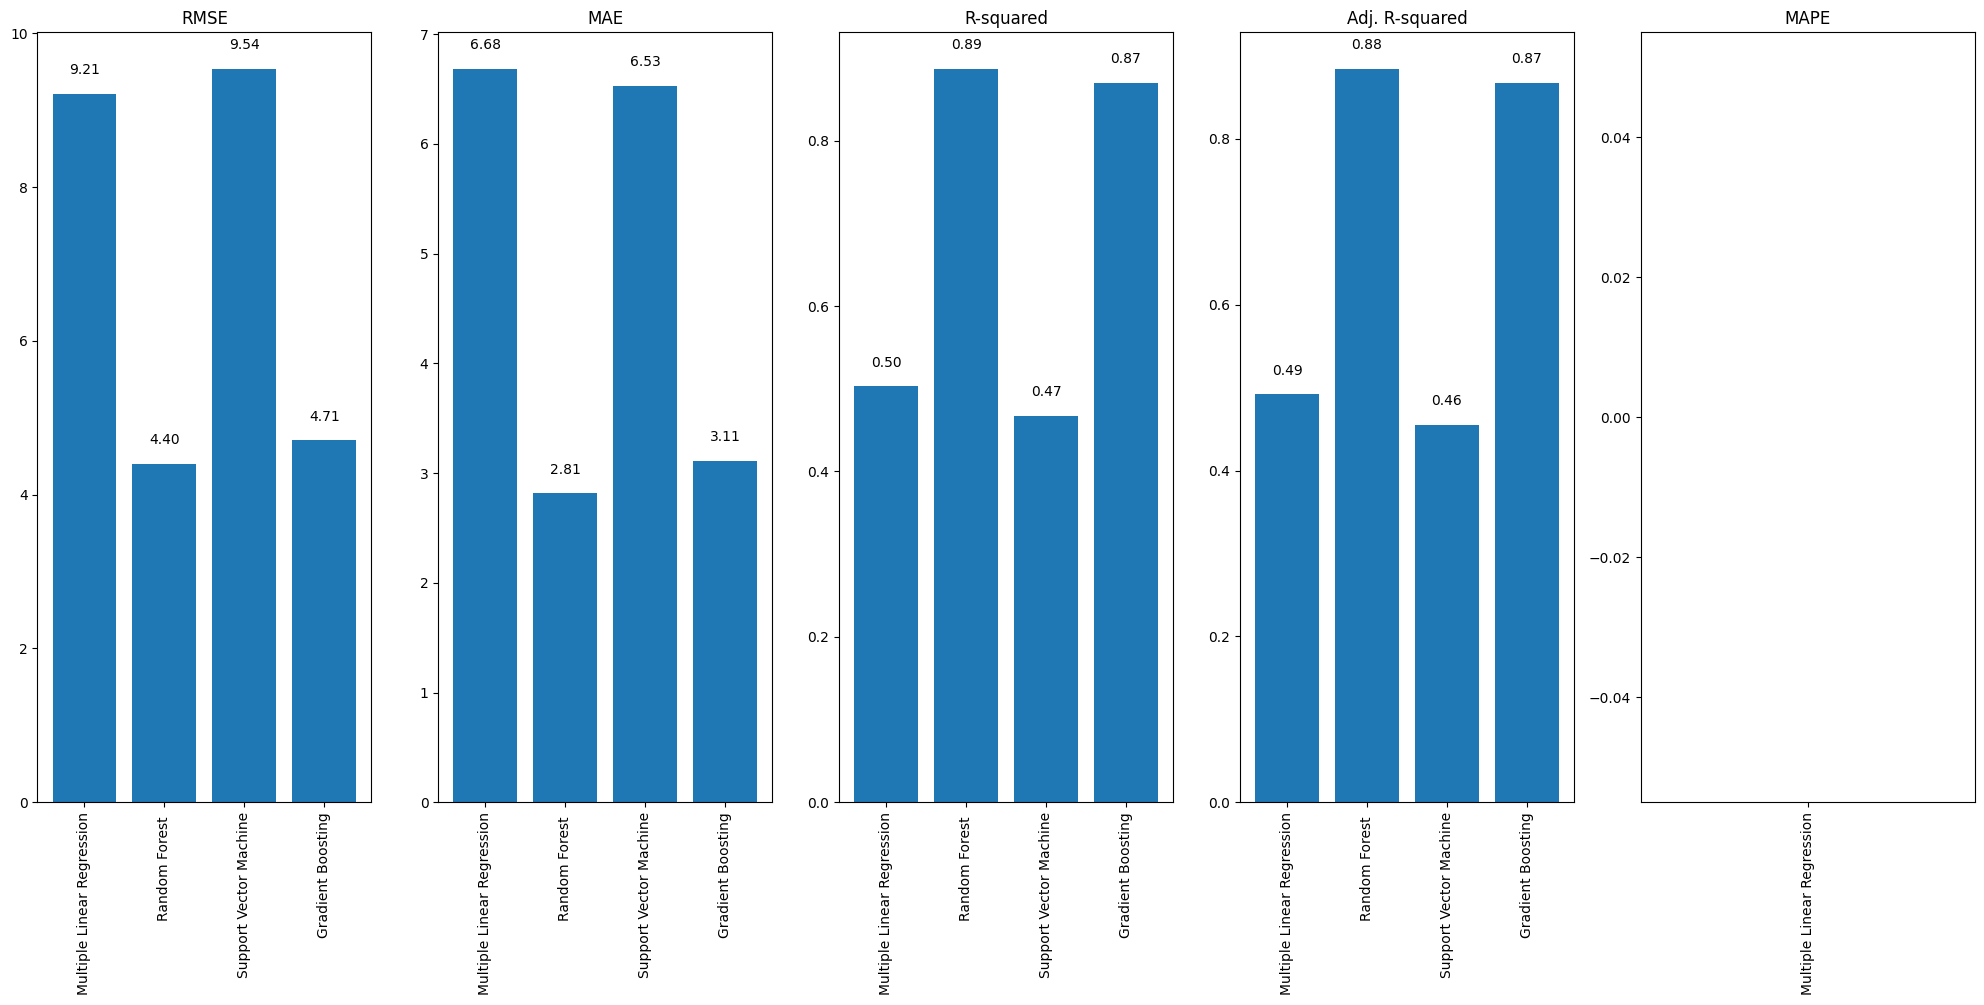

In [46]:
plot_model_comparison(df_melted)

In [47]:
#Hyperparameter tunning for Random Forest

# Define the hyperparameter search space
param_dist = {
    'n_estimators': np.arange(50, 501, 50),  # Expanded range
    'max_depth': [None, 5, 10, 20],  # Added values
    'min_samples_split': np.arange(2, 11, 2),  # Expanded range
    'min_samples_leaf': np.arange(1, 5, 1),  # Added values
    'max_features': [None, 'sqrt', 'log2'],  # Added options
    'bootstrap': [True, False],  # Added option
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Evaluation metric
    random_state=53,  # For reproducibility
    n_jobs=-1,  # Use all available cores for parallel processing
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

In [48]:
best_params = {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': True}
# Random Forest Regressor
best_model = RandomForestRegressor(**best_params)

# Fitting the model
best_model = best_model.fit(X_train, y_train)

# Evaluate the tuned random forest model on the validation data
RF_tuned_model =  model_performance_regression(best_model, X_val, y_val)
RF_tuned_model

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.424616,2.82887,0.88521,0.882702,inf


In [49]:
#Fine tuned model performance comparison

models_test_comp_df = pd.concat(
    [
        rf_regressor_perf_test.T,
        RF_tuned_model.T,
        ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Random Forest ",
    "Fine-tuned Random Forest",
    ]


print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Random Forest,4.397454,2.814914,0.886615,0.884137,inf
Fine-tuned Random Forest,4.424616,2.828870,0.885210,0.882702,inf


In [50]:
# Melt the DataFrame to long format for Seaborn
df_melted = pd.melt(models_test_comp_df, var_name='Model', value_name='Value', ignore_index = False)
df_melted.reset_index(inplace=True)
df_melted

,index,Model,Value
0,RMSE,Random Forest,4.397454
1,MAE,Random Forest,2.814914
2,R-squared,Random Forest,0.886615
3,Adj. R-squared,Random Forest,0.884137
4,MAPE,Random Forest,inf
5,RMSE,Fine-tuned Random Forest,4.424616
6,MAE,Fine-tuned Random Forest,2.828870
7,R-squared,Fine-tuned Random Forest,0.885210
8,Adj. R-squared,Fine-tuned Random Forest,0.882702
9,MAPE,Fine-tuned Random Forest,inf


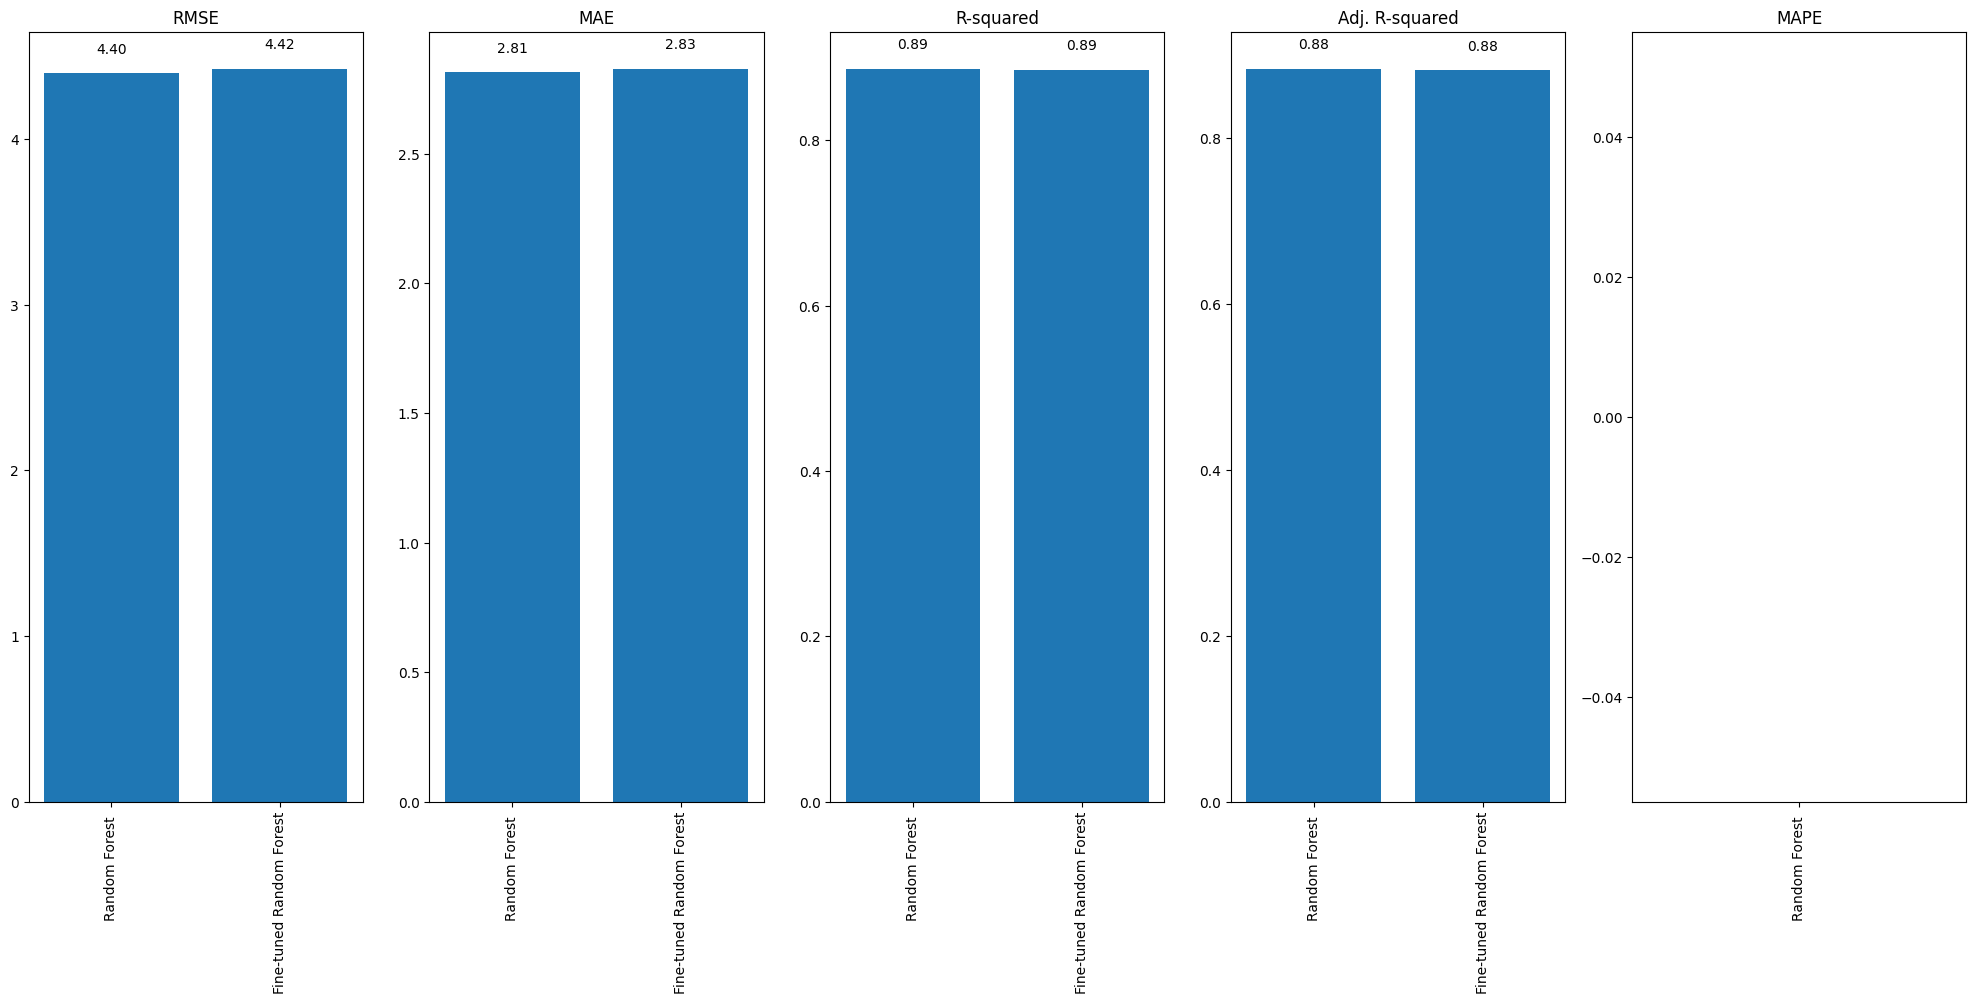

In [51]:
plot_model_comparison(df_melted)

In [52]:
# Evaluate the best model on the test data
RF_tuned_model =  model_performance_regression(best_model, X_test, y_test)
RF_tuned_model

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,4.205658,2.725017,0.892186,0.889828,46.378053


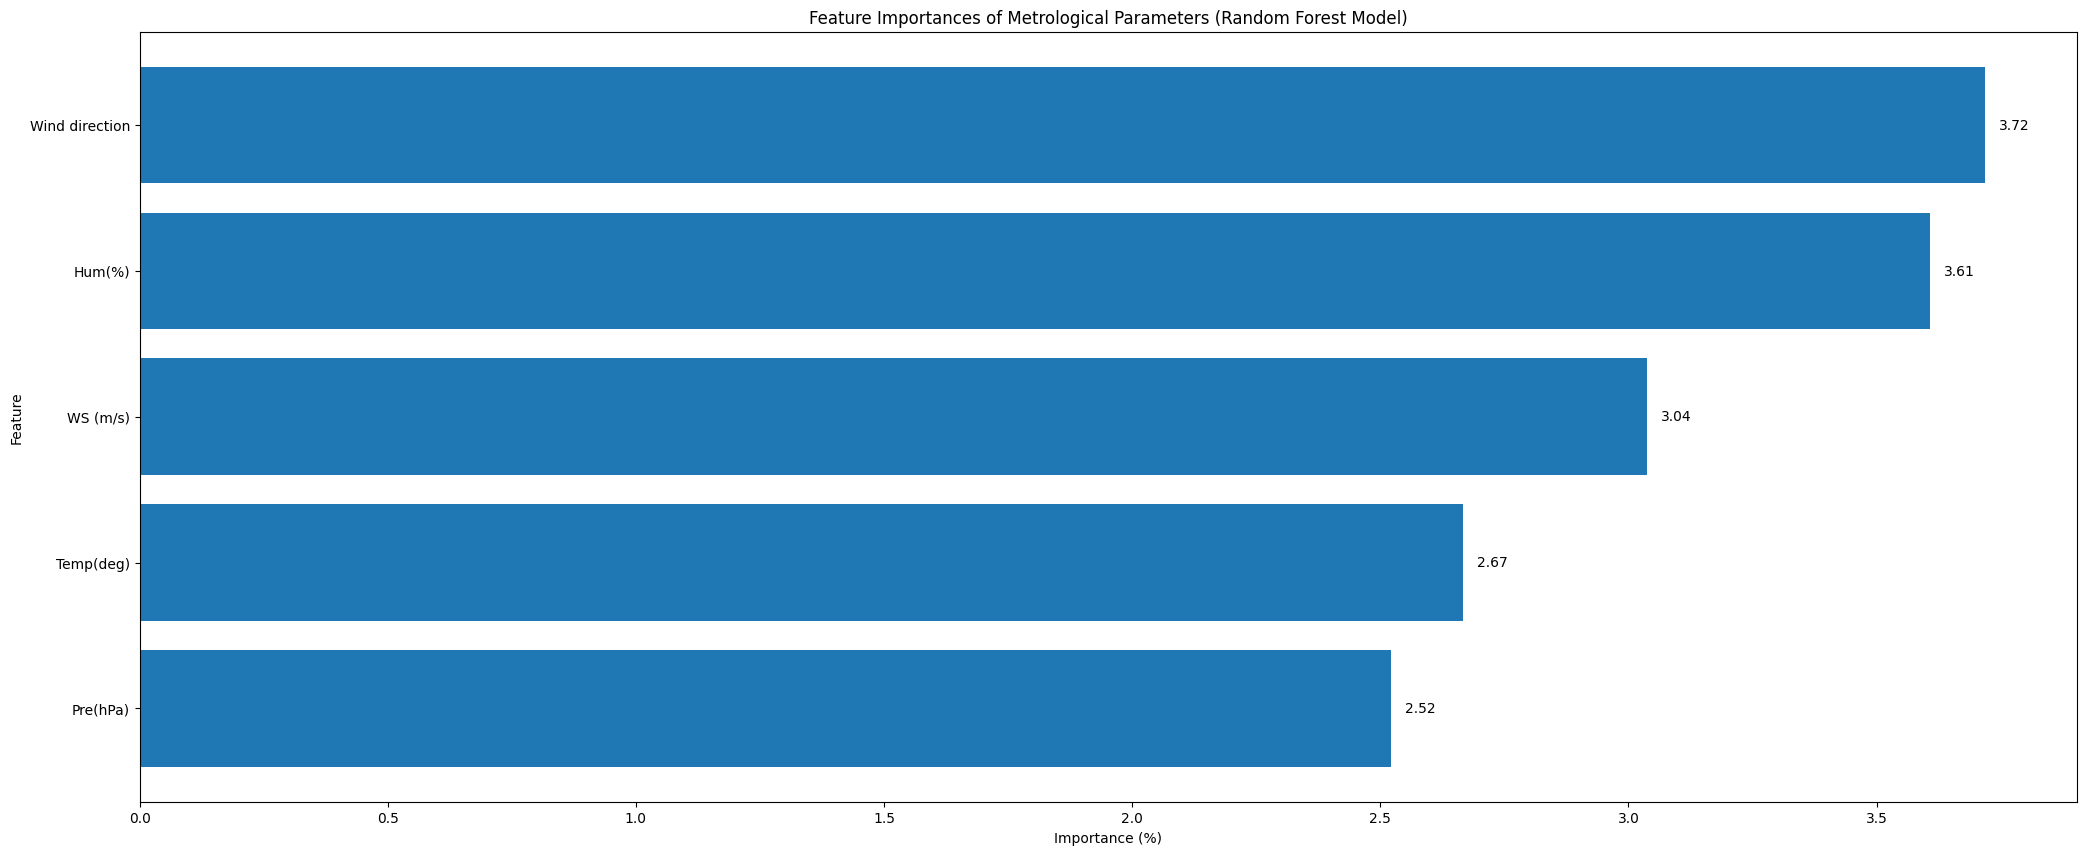

In [53]:
# Feature importance of the best model (Random Forest model)
# Get feature importances
importances = rf_regressor.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort importances and feature names
importances, feature_names = zip(*sorted(zip(importances*100, feature_names)))

#Keep only Metrological Features
features_to_keep = ['Temp(deg)', 'Hum(%)', 'Pre(hPa)', 'WS (m/s)','Wind direction']

importance =  [importance for importance, feature_name in zip(importances, feature_names) if feature_name in features_to_keep]
feature_names = [name for name in feature_names if name in features_to_keep]

# Create a vertical bar chart
plt.figure(figsize=(25, 10))
plt.barh(feature_names, importance)

# Show plot

# Get the current Axes object
ax = plt.gca()
# Add value labels on top of bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=10)

# Set title and axis labels
plt.title("Feature Importances of Metrological Parameters (Random Forest Model)")
plt.xlabel("Importance (%)")
plt.ylabel("Feature")

# Show the plot
plt.show();

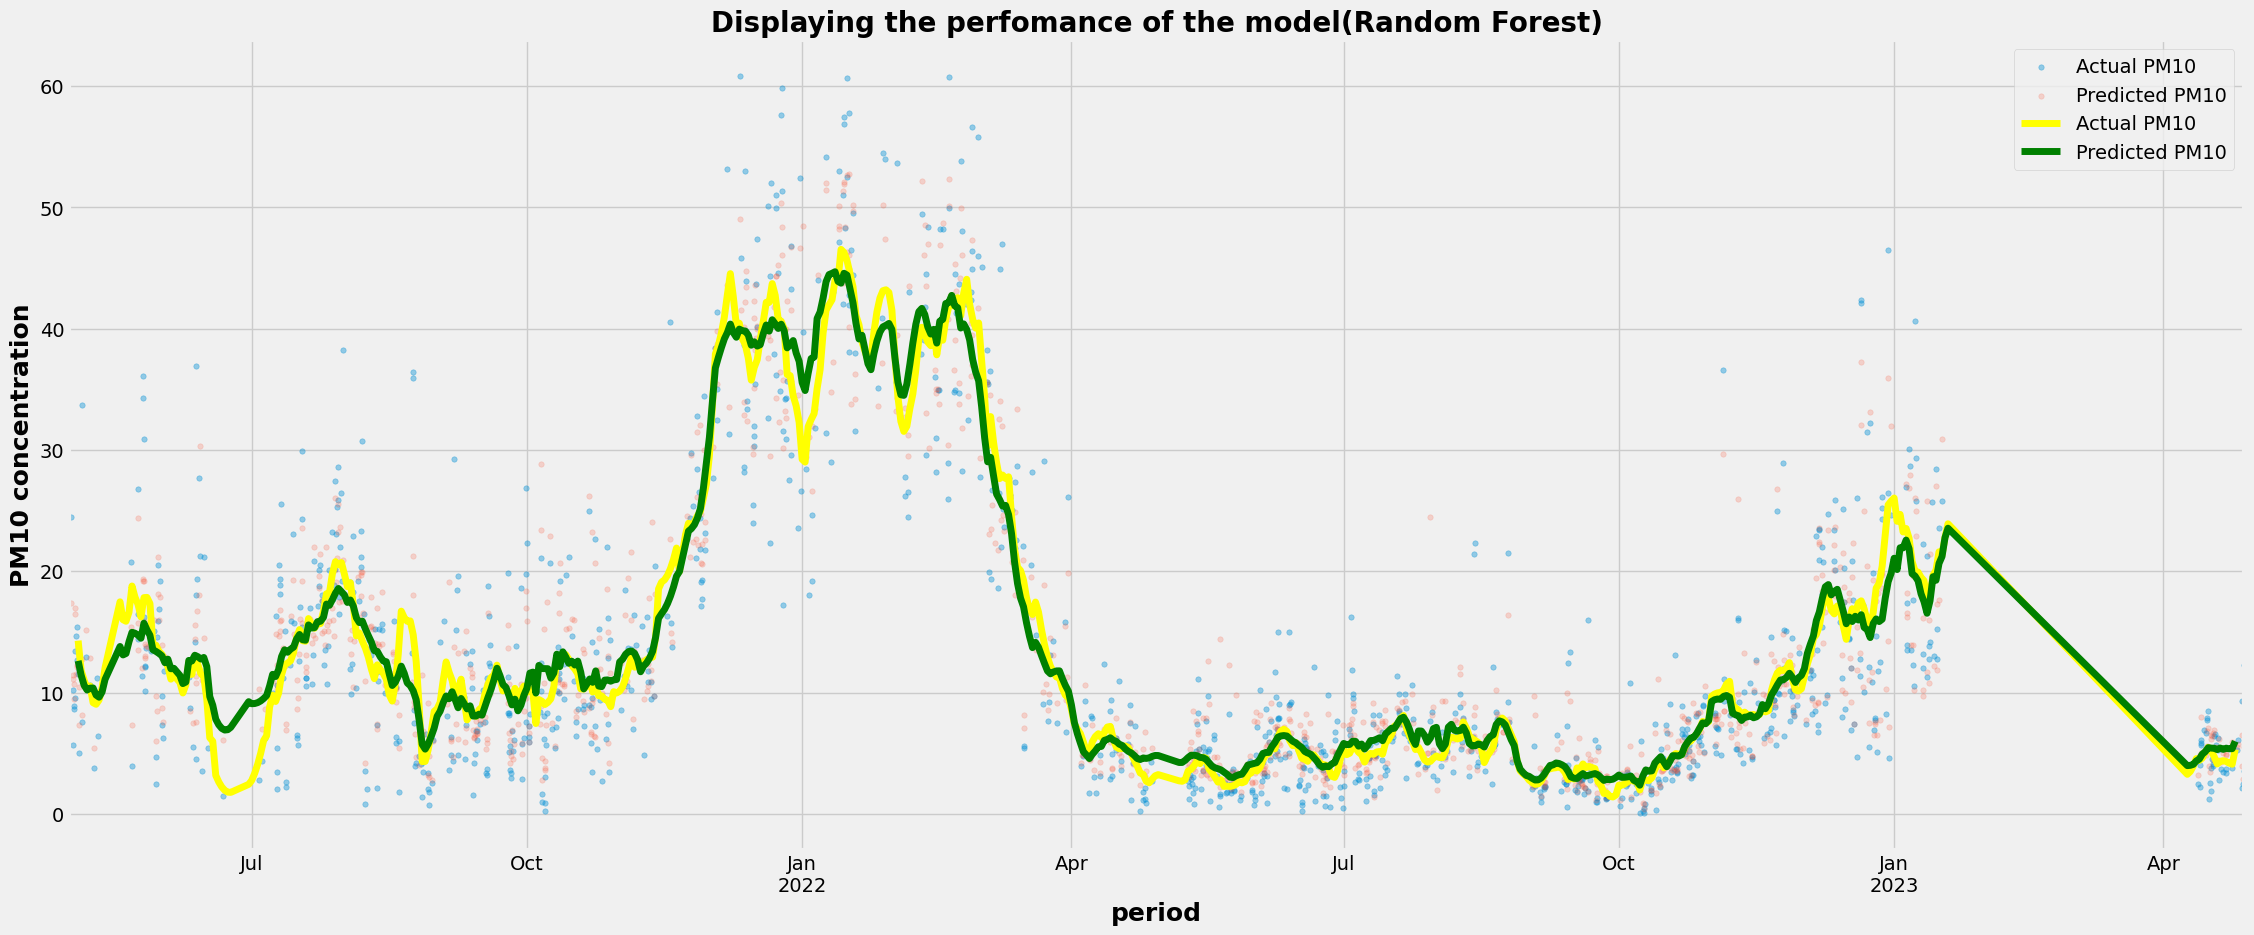

In [54]:
# we now use the best model (Random forest model) to predict the PM10
# concetration and compare it to the actual PM10 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'Actual PM10':y_test,
                            'Predicted PM10':best_model.predict(X_test.values)})
colors = {
    "Actual PM10": "yellow",
    "Predicted PM10": "green",
}

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(25,10))
    plt.scatter(compare_data.index,compare_data['Actual PM10'],s=15,label='Actual PM10',
               alpha=.4)
    plt.scatter(compare_data.index,compare_data['Predicted PM10'],s=15,label='Predicted PM10',
               alpha=.2)

    compare_daily_data = compare_data.resample('D').median()
    compare_daily_data.interpolate(inplace=True)

    for column in compare_daily_data.columns:
      decomposition = seasonal_decompose(compare_daily_data[column], model='addictive')
      # plot the data
      decomposition.trend.plot(linestyle='-', alpha =1, color=colors.get(column, "grey"), linewidth=5,legend=True, label=column)

    plt.legend()
    plt.title('Displaying the perfomance of the model(Random Forest)',
             fontsize=20, fontweight='bold')
    plt.xlabel('period',fontsize=18, fontweight='bold')
    plt.ylabel('PM10 concentration',fontsize=18, fontweight='bold')
    plt.show();

In [55]:
# Linear fitting of predicted and actual values for the best model (Random Forest model)
lr = LinearRegression()
lr.fit(compare_data['Predicted PM10'].values.reshape(-1,1), compare_data['Actual PM10'])

# Make predictions using the linear regression model
predicted_values_lr = lr.predict(compare_data['Predicted PM10'].values.reshape(-1,1))

# Evaluate the model
r_squared = r2_score(compare_data['Actual PM10'], predicted_values_lr)
r_squared

0.8926854619493833

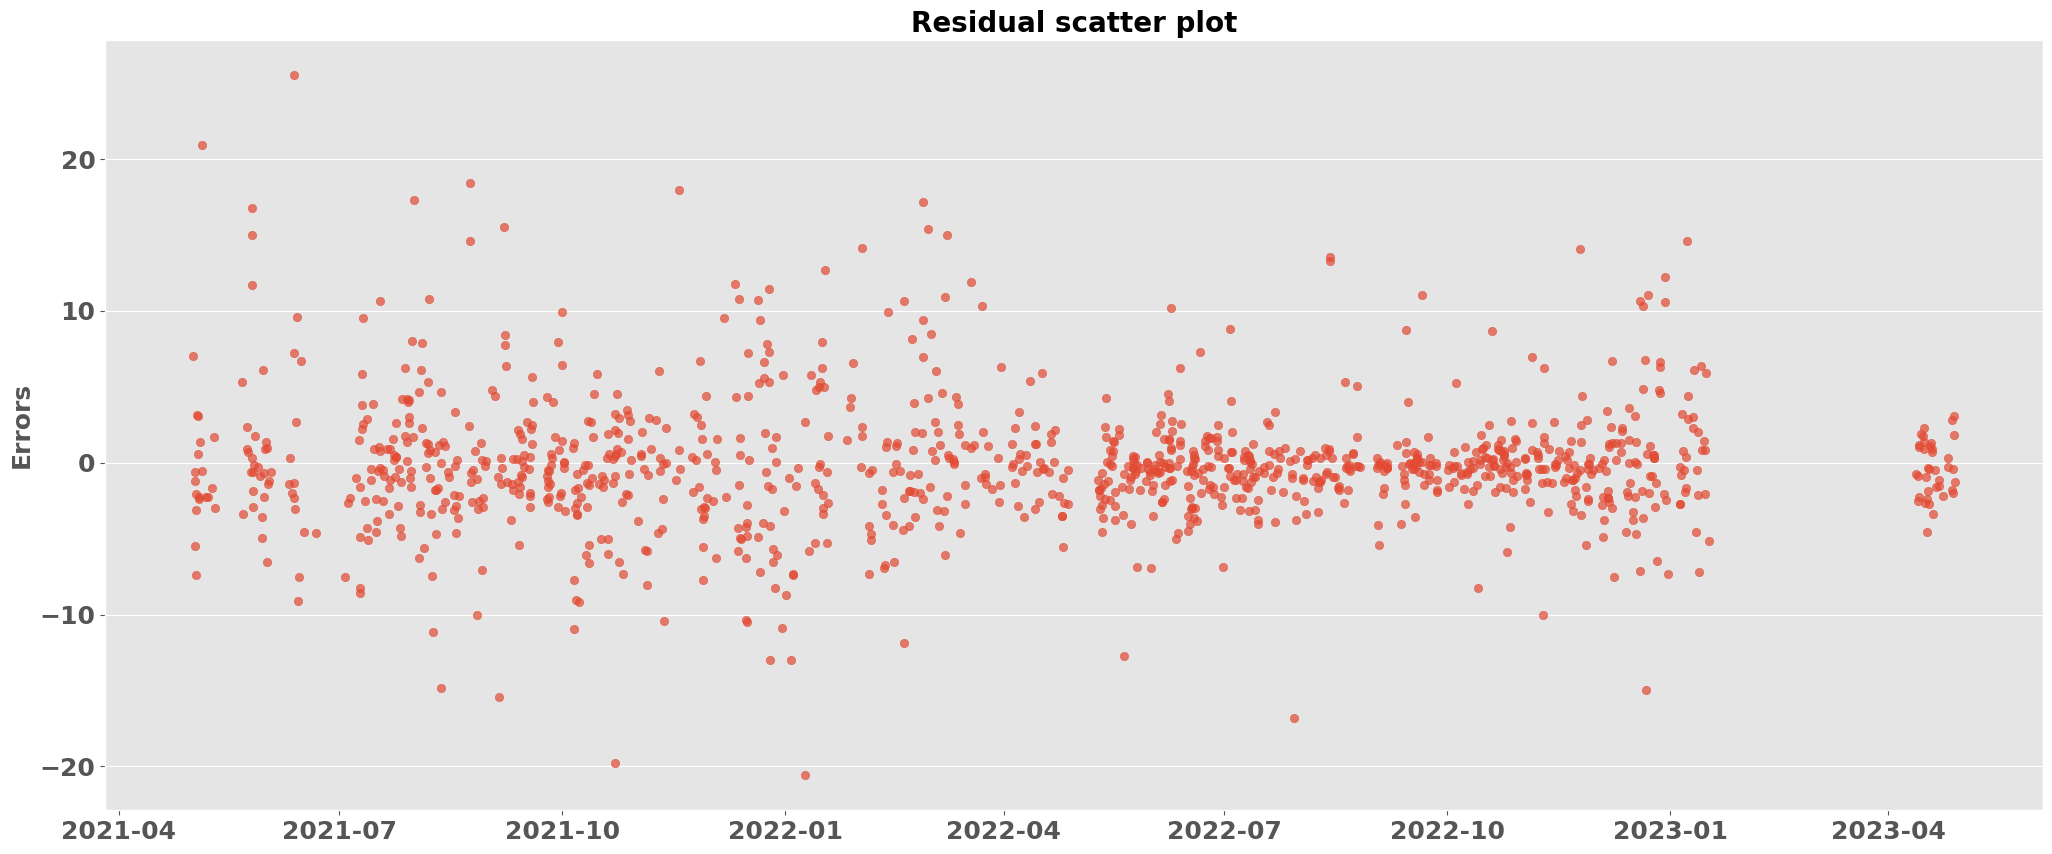

In [56]:
# calculate the errors
compare_data['Residuals'] = compare_data['Actual PM10'] - compare_data['Predicted PM10']

# make a scatter plot of the errors to see if they follow any pattern
with plt.style.context('ggplot'):
    plt.figure(figsize=(25,10))
    plt.scatter(compare_data.index,compare_data.Residuals,alpha=.7)
    plt.title('Residual scatter plot',fontsize=20, fontweight='bold')
    plt.ylabel('Errors',fontsize=18, fontweight='bold')
    plt.grid(axis='x')
    # Get the current Axes object
    ax = plt.gca()
    # Increase the size of the x and y tick labels
    ax.tick_params(axis='both', which='major', labelsize=18)

    # Set the font weight to bold for x and y tick labels
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.show();

<Figure size 2500x1000 with 0 Axes>

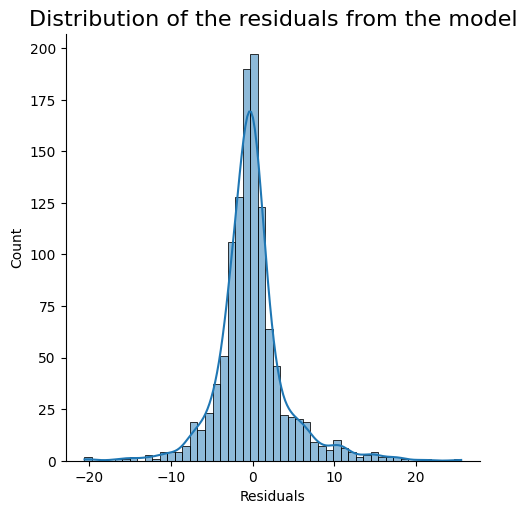

In [57]:
# plot the histogram to see check the normality of the errors
plt.figure(figsize=(25,10))
sns.displot(compare_data.Residuals,bins=50, kde = True, lw=5)
plt.title('Distribution of the residuals from the model',
         fontsize=16)
plt.show();